In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [2]:
all_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
len(train_data), len(test_data)

(198, 200)

0 1 2 3 4 5 6 7 8 9 CPU times: user 5.19 s, sys: 3.36 s, total: 8.56 s
Wall time: 10.6 s


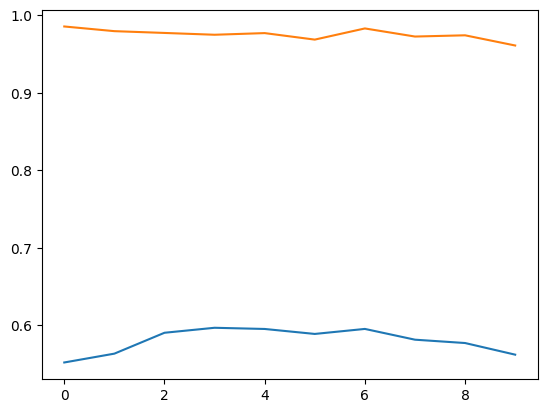

In [6]:
%%time
model = flg_model.ThreeStepModel()
model.step1Heatmap.n_epochs = 1000
model.train(train_data)
plt.figure()
plt.plot(model.step1Heatmap.train_loss_list1)
plt.plot(model.step1Heatmap.train_loss_list2)
fls.dill_save(fls.temp_dir + 'model_temp.pickle', model)

In [4]:
model = fls.dill_load(fls.temp_dir + 'model_temp.pickle')
inferred_test_data = model.infer(test_data);
inferred_train_data = model.infer(train_data);
# for inf,test in zip(inferred_test_data, this_test_data):
#     print('')
#     print('')
#     print(test.name)
#     print(test.labels)
#     print(inf.labels)

KeyboardInterrupt: 

In [ ]:
fls.dill_save(fls.temp_dir + 'res.pickle', (inferred_test_data, test_data, inferred_train_data, train_data))

In [ ]:
importlib.reload(fls)
inferred_test_data, test_data, inferred_train_data, train_data = fls.dill_load(fls.temp_dir + 'res.pickle')

In [ ]:
import sklearn
import pandas as pd

def distance_metric(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    thresh_ratio: float,
    min_radius: float,
):
    coordinate_cols = ['Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    label_tensor = solution[coordinate_cols].values.reshape(len(solution), -1, len(coordinate_cols))
    predicted_tensor = submission[coordinate_cols].values.reshape(len(submission), -1, len(coordinate_cols))
    # Find the minimum euclidean distances between the true and predicted points
    solution['distance'] = np.linalg.norm(label_tensor - predicted_tensor, axis=2).min(axis=1)
    # Convert thresholds from angstroms to voxels
    solution['thresholds'] = solution['Voxel spacing'].apply(lambda x: (min_radius * thresh_ratio) / x)
    solution['predictions'] = submission['Has motor'].values
    solution.loc[(solution['distance'] > solution['thresholds']) & (solution['Has motor'] == 1) & (submission['Has motor'] == 1), 'predictions'] = 0
    return solution['predictions'].values
    
def score(solution: pd.DataFrame, submission: pd.DataFrame, min_radius: float, beta: float) -> float:
    """
    Parameters:
    solution (pd.DataFrame): DataFrame containing ground truth motor positions.
    submission (pd.DataFrame): DataFrame containing predicted motor positions.

    Returns:
    float: FBeta score.

    Example
    --------
    >>> solution = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [-1, 250, 100, 200],
    ...     'Motor axis 1': [-1, 250, 100, 200],
    ...     'Motor axis 2': [-1, 250, 100, 200],
    ...     'Voxel spacing': [10, 10, 10, 10],
    ...     'Has motor': [0, 1, 1, 1]
    ... })
    >>> submission = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [100, 251, 600, -1],
    ...     'Motor axis 1': [100, 251, 600, -1],
    ...     'Motor axis 2': [100, 251, 600, -1]
    ... })
    >>> score(solution, submission, 1000, 2)
    0.3571428571428571
    """

    solution = solution.sort_values('tomo_id').reset_index(drop=True)
    submission = submission.sort_values('tomo_id').reset_index(drop=True)

    filename_equiv_array = solution['tomo_id'].eq(submission['tomo_id'], fill_value=0).values

    if np.sum(filename_equiv_array) != len(solution['tomo_id']):
        raise ValueError('Submitted tomo_id values do not match the sample_submission file')

    submission['Has motor'] = 1
    # If any columns are missing an axis, it's marked with no motor
    select = (submission[['Motor axis 0', 'Motor axis 1', 'Motor axis 2']] == -1).any(axis='columns')
    submission.loc[select, 'Has motor'] = 0

    cols = ['Has motor', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    assert all(col in submission.columns for col in cols)

    # Calculate a label of 0 or 1 using the 'has motor', and 'motor axis' values
    predictions = distance_metric(
        solution,
        submission,
        thresh_ratio=1.0,
        min_radius=min_radius,
    )

    return sklearn.metrics.fbeta_score(solution['Has motor'].values, predictions, beta=beta)

In [ ]:
row_df_sub = fls.create_submission_dataframe(inferred_test_data, reference_data = test_data)
row_df_ref = fls.create_submission_dataframe(test_data, reference_data = test_data, include_voxel_spacing=True)
print(score(row_df_ref, row_df_sub, 1000, 2))

In [ ]:
train_data_1_motor = []
inferred_train_data_1_motor = []
for i,t in zip(inferred_train_data, train_data):
    if len(t.labels)<=1:
        train_data_1_motor.append(t)
        inferred_train_data_1_motor.append(i)
    
row_df_sub = fls.create_submission_dataframe(inferred_train_data_1_motor, reference_data = train_data_1_motor)
row_df_ref = fls.create_submission_dataframe(train_data_1_motor, reference_data = train_data_1_motor, include_voxel_spacing=True)
print(score(row_df_ref, row_df_sub, 1000, 2))